<a href="https://colab.research.google.com/github/ekotyoo/Racana/blob/racana-ml/Deep_Learning_Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle


from tensorflow import keras
from collections import deque
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Flatten
from keras.models import Model
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.metrics import mean_squared_error



In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Preparing Data Set
memasukan data tempat wisata

In [3]:
link = 'https://drive.google.com/file/d/1Fjjh_nSMWssHE4Ncv7aURngnN5wsfJ_y/view'


# to get the id part of the file
id = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('tourism_with_id.csv')

place = pd.read_csv('tourism_with_id.csv')
print(place)


    Place_Id                     Place_Name  \
0          1              Agrowisata Satria   
1          2                     Agung Bali   
2          3  Wisata Air Panas Toya Bungkah   
3          4         Air Terjun Aling-Aling   
4          5          Air Terjun Tegenungan   
..       ...                            ...   
70        71         Teras Sawah Tegalalang   
71        72                   Tirta Gangga   
72        73                  Waterbom Bali   
73        74       Alas Harum Agro Tourism    
74        75     Wisata Agro Teba Sari Bali   

                                          Description  Weekend Holiday Price  \
0   Agrowisata Satria menawarkan 'rasa' Bali pada ...                  50000   
1   Dapatkan berbagai produk oleh-oleh khas Bali b...                      0   
2   Pemandian air panas di dekat gunung Batur (Pem...                  70000   
3   Keberadaan air terjun ini semakin mempercantik...                  20000   
4   Bosan dengan wisata alam pantai

In [4]:
# Melihat gambaran data place

place.head()

,Place_Id,Place_Name,Description,Weekend Holiday Price,Weekday Price,Category,City,Rating,Alamat,Coordinate,Lat,Long,Gambar
0,1,Agrowisata Satria,Agrowisata Satria menawarkan 'rasa' Bali pada ...,50000,50000,Agrowisata,Gianyar,3.0,"Manukaya, Kec. Tampaksiring, Kabupaten Gianya...","-8.402228546131536, 115.32296693687739",-8.402229,115.322967,V
1,2,Agung Bali,Dapatkan berbagai produk oleh-oleh khas Bali b...,0,0,Belanja,Badung,4.0,"Jln. Dewi Sri No.18XX, Kuta, Badung, Bali","-8.700234336021559, 115.176534407375",-8.700234,115.176534,V
2,3,Wisata Air Panas Toya Bungkah,Pemandian air panas di dekat gunung Batur (Pem...,70000,70000,Alam,Bangli,4.0,"Batur Tengah, Kec. Kintamani, Kabupaten Bangli...","-8.251298580809106, 115.39981444195475",-8.251299,115.399814,V
3,4,Air Terjun Aling-Aling,Keberadaan air terjun ini semakin mempercantik...,20000,20000,Alam,Buleleng,4.5,"Jl. Raya Desa Sambangan, Banjar, Sambangan, Ke...","-8.173073590748519, 115.10513024047802",-8.173074,115.105130,V
4,5,Air Terjun Tegenungan,Bosan dengan wisata alam pantai dan ingin meni...,20000,20000,Alam,Gianyar,4.0,"Jl. Ir. Sutami, Kemenuh, Kec. Sukawati, Kabupa...","-8.575191460385602, 115.28870189592831",-8.575191,115.288702,V


In [ ]:
place.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Place_Id               75 non-null     int64  
 1   Place_Name             75 non-null     object 
 2   Description            75 non-null     object 
 3   Weekend Holiday Price  75 non-null     int64  
 4   Weekday Price          75 non-null     int64  
 5   Category               75 non-null     object 
 6   City                   75 non-null     object 
 7   Rating                 75 non-null     float64
 8   Alamat                 75 non-null     object 
 9   Coordinate             75 non-null     object 
 10  Lat                    75 non-null     float64
 11  Long                   75 non-null     float64
 12  Gambar                 75 non-null     object 
dtypes: float64(3), int64(3), object(7)
memory usage: 7.7+ KB


Memasukkan data rating

In [6]:
rate =  'https://drive.google.com/file/d/1O8nHRBufcBe26vB8GHicaTTqAlIcUv8E/view'

# to get the id part of the file
id = rate.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('tourism_rating.csv')

rating = pd.read_csv('tourism_rating.csv')
rating.head()

,User_Id,Place_Id,Nama Tempat,Place_Rating
0,1,2,Agung Bali Oleh-Oleh,3
1,1,7,Aloha Ubud Swing,5
2,1,8,Bali Bird Park,5
3,1,12,Big Garden Corner,2
4,1,13,Wanagiri Hidden Hills,5


In [7]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User_Id       3000 non-null   int64 
 1   Place_Id      3000 non-null   int64 
 2   Nama Tempat   3000 non-null   object
 3   Place_Rating  3000 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 93.9+ KB


Filtering data rating

In [8]:
min_place_rating = 10
filter_place = (rating["Place_Id"].value_counts()>min_place_rating)
filter_place = filter_place[filter_place].index.tolist()

min_user_rating = 10
filter_user = (rating["User_Id"].value_counts()>min_user_rating)
filter_user = filter_user[filter_user].index.tolist()

data_filtered = rating[(rating["Place_Id"].isin(filter_place)) & 
                       (rating["User_Id"].isin(filter_place))]
del filter_place,filter_user,min_place_rating,min_user_rating
print('Shape User-Ratings unfiltered:\t{}'.format(rating.shape))
print('Shape User-Ratings filtered:\t{}'.format(data_filtered.shape))

Shape User-Ratings unfiltered:	(3000, 4)
Shape User-Ratings filtered:	(2250, 4)


Membagi data set menjadi train dan test

In [9]:
data_filtered = data_filtered.sample(frac=1).reset_index(drop=True)

n =500

df_train = data_filtered[:-n]
df_test = data_filtered[-n:]

#Deep Learning With Keras
Using collaborative Filtering


In [10]:
# Mapping user dan place id
user_mapping = {id:i for i, id in enumerate(data_filtered['User_Id'].unique())}
place_mapping = {id:i for i, id in enumerate(data_filtered['Place_Id'].unique())}


y_train = df_train["Place_Rating"].apply(lambda x: (x - 1) / (5 - 1)).values
y_test = df_test["Place_Rating"].apply(lambda x: (x - 1) / (5 - 1)).values

x_train = df_train[['User_Id', 'Place_Id']].values
x_test = df_test[['User_Id', 'Place_Id']].values
# Atur Variabel
user_embedding_size = 20
place_embedding_size = 10

# Masukin parameter
users = len(user_mapping)
places = len(place_mapping)
embedding_size = 10

Mulai Pembuatan Model

In [12]:


#Mengatur input layer
user_id_input = Input(shape=[1], name='user')
place_id_input = Input(shape=[1], name='place')

# Membuat Embedding layer
user_embedding = Embedding(output_dim=user_embedding_size, 
                           input_dim=users+1,
                           input_length=1, 
                           name='user_embedding')(user_id_input)
place_embedding = Embedding(output_dim=place_embedding_size, 
                            input_dim=places+1,
                            input_length=1, 
                            name='item_embedding')(place_id_input)

# Reshape embedding layers yang sudah dibuat
user_vector = Flatten(name="Flatten-Users")(user_embedding)
place_vector = Flatten(name="Flatten-Places")(place_embedding)

# Di concate supaya bisa jadi 1 list
concat = Concatenate()([user_vector, place_vector])

# masukin dense layer
fc1 = Dense(64, activation='relu')(concat)
fc2 = Dense(64, activation='relu')(fc1)
fc3 = Dense(64, activation='relu')(fc2)

y = Dense(1)(fc3)



In [13]:
# Setup model yang sudah dibuat
model = Model(inputs=[user_id_input, place_id_input], outputs=y)
model.compile(
    loss = 'mse',
    optimizer = keras.optimizers.Adam(learning_rate=0.0004),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# Hasil fit model
history = model.fit([x_train[:,0],x_train[:,1]],
          y_train,
          validation_data = ([x_test[:,0], x_test[:,1]], y_test),
          batch_size=256, 
          epochs=100,
          )


Epoch 1/100
7/7 [==============================] - 3s 30ms/step - loss: 0.6628 - root_mean_squared_error: 0.8141 - val_loss: 0.6064 - val_root_mean_squared_error: 0.7787
Epoch 2/100
7/7 [==============================] - 0s 6ms/step - loss: 0.5935 - root_mean_squared_error: 0.7704 - val_loss: 0.5364 - val_root_mean_squared_error: 0.7324
Epoch 3/100
7/7 [==============================] - 0s 5ms/step - loss: 0.5170 - root_mean_squared_error: 0.7190 - val_loss: 0.4561 - val_root_mean_squared_error: 0.6753
Epoch 4/100
7/7 [==============================] - 0s 5ms/step - loss: 0.4287 - root_mean_squared_error: 0.6548 - val_loss: 0.3633 - val_root_mean_squared_error: 0.6028
Epoch 5/100
7/7 [==============================] - 0s 6ms/step - loss: 0.3284 - root_mean_squared_error: 0.5731 - val_loss: 0.2623 - val_root_mean_squared_error: 0.5121
Epoch 6/100
7/7 [==============================] - 0s 5ms/step - loss: 0.2230 - root_mean_squared_error: 0.4722 - val_loss: 0.1653 - val_root_mean_squared

Mencoba Model 

In [14]:
# Test model
y_pred = model.predict([x_test[:,0],x_test[:,1]])
#  calculate RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
print('\n\nTesting Result With Keras Matrix-Factorization: {:.4f} RMSE'.format(rmse))



Testing Result With Keras Matrix-Factorization: 0.2945 RMSE


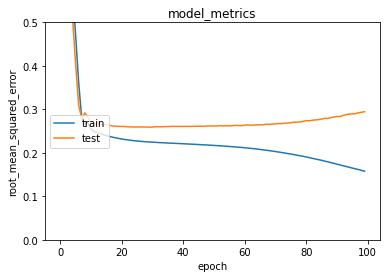

In [15]:
# Menampilkan plot loss dan validation

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.ylim(ymin=0, ymax=0.5)
plt.legend(['train', 'test'], loc='center left')
plt.show()

# Mulai Predicting 

In [16]:
# Menyiapkan dataframe
place_df = place[['Place_Id','Place_Name','Category','Rating','Weekend Holiday Price']]
place_df.columns = ['id','place_name','category','rating','price']
df = rating.copy()


In [17]:
user_id = df.User_Id.sample(1).iloc[0]
place_visited_by_user = df[df.User_Id == user_id]

In [18]:
def dict_encoder(col, data=df):

  # Mengubah kolom suatu dataframe menjadi list tanpa nilai yang sama
  unique_val = data[col].unique().tolist()

  # Melakukan encoding value kolom suatu dataframe ke angka
  val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}

  # Melakukan proses encoding angka ke value dari kolom suatu dataframe
  val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
  return val_to_val_encoded, val_encoded_to_val

In [19]:
# Encoding Place_Id
place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id')

# Mapping Place_Id ke dataframe place
df['place'] = df['Place_Id'].map(place_to_place_encoded)

In [20]:
# Encoding User_Id
user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id')

# Mapping User_Id ke dataframe
df['user'] = df['User_Id'].map(user_to_user_encoded)

In [21]:
# Mendapatkan jumlah user dan place
num_users, num_place = len(user_to_user_encoded), len(place_to_place_encoded)
 
# Mengubah rating menjadi nilai float
df['Place_Rating'] = df['Place_Rating'].values.astype(np.float32)
 
# Mendapatkan nilai minimum dan maksimum rating
min_rating, max_rating = min(df['Place_Rating']), max(df['Place_Rating'])
 
print(f'Number of User: {num_users}, Number of Place: {num_place}, Min Rating: {min_rating}, Max Rating: {max_rating}')

Number of User: 100, Number of Place: 75, Min Rating: 1.0, Max Rating: 5.0


In [22]:
# Membuat data lokasi yang belum dikunjungi user
place_not_visited = place_df[~place_df['id'].isin(place_visited_by_user.Place_Id.values)]['id'] 
place_not_visited = list(
    set(place_not_visited)
    .intersection(set(place_to_place_encoded.keys()))
)
 
place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)

In [24]:
find = model.predict([user_place_array[:,0],user_place_array[:,1]])
rate =[]
for i in find:
  rate.append(i[0])
rate = pd.Series(rate)

Get the recommended place -id


In [26]:
top_ratings_indices = rate.argsort()[:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]
recommended_place_ids = list(recommended_place_ids)
print(recommended_place_ids)


[52, 51, 74, 42, 25, 38, 20, 23, 55, 61, 62, 24, 13, 69, 22, 1, 17, 39, 71, 73, 36, 30, 4, 43, 21, 58, 60, 44, 46, 66, 10, 2, 64, 70, 11, 53, 28, 65, 27, 47, 6, 37, 15, 50, 49]


In [25]:
model.save("model.h5")

In [27]:
print('Daftar rekomendasi untuk: {}'.format('User ' + str(user_id)))
print('===' * 15,'\n')
print('----' * 15)
print('Tempat dengan rating wisata paling tinggi dari user')
print('----' * 15)
 
top_place_user = (
    place_visited_by_user.sort_values(
        by = 'Place_Rating',
        ascending=False
    )
    .head(5)
    .Place_Id.values
)
 
place_df_rows = place_df[place_df['id'].isin(top_place_user)]
for row in place_df_rows.itertuples():
    print(row.place_name, ':', row.category)

print('')
print('----' * 15)
print('Top 7 place recommendation')
print('----' * 15)
 
recommended_place = place_df[place_df['id'].isin(recommended_place_ids)]
for row, i in zip(recommended_place.itertuples(), range(1,8)):
    print(i,'.', row.place_name, '\n    ', row.category, ',', 'Harga Tiket Masuk ', row.price, ',', 'Rating Wisata ', row.rating,'\n')

print('==='*15)

Daftar rekomendasi untuk: User 7

------------------------------------------------------------
Tempat dengan rating wisata paling tinggi dari user
------------------------------------------------------------
Aloha Ubud Swing  : Agrowisata
Bali Bird Park : Cagar Alam
Watersport Tanjung Benoa Bali : Alam
Tirta Gangga : Religius
Wisata Agro Teba Sari Bali : Agrowisata

------------------------------------------------------------
Top 7 place recommendation
------------------------------------------------------------
1 . Agrowisata Satria 
     Agrowisata , Harga Tiket Masuk  50000 , Rating Wisata  3.0 

2 . Agung Bali 
     Belanja , Harga Tiket Masuk  0 , Rating Wisata  4.0 

3 . Air Terjun Aling-Aling 
     Alam , Harga Tiket Masuk  20000 , Rating Wisata  4.5 

4 . Air Terjun Tukad Cepung 
     Alam , Harga Tiket Masuk  15000 , Rating Wisata  4.5 

5 . Bali Swing 
     Rekreasi , Harga Tiket Masuk  500000 , Rating Wisata  4.5 

6 . Batik Koleksi Sari Amerta 
     Budaya , Harga Tiket Mas